In [1]:
import sys
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_HVC = 600, 150, 20

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
aud_real = dict(np.load('learned_song_responses.npz')) # (n_songs, N, T)
N_in = aud_real['ctrl'].shape[1]
loc_in = np.linspace(0, 1, num=N_in, endpoint=False)
loc_E = np.linspace(0, 1, num=NE, endpoint=False)
mapping = np.exp(-(loc_in[:,None]-loc_E[None,:])**2/3e-5)
# mapping = rng.normal(size=(N_in, NE))
# p1 = 1/N_in
# mapping = rng.choice((-1, 0, 1), size=(N_in, NE), replace=True, p=(p1, 1-2*p1, p1))

In [5]:
for k in ('ctrl', 'pert_weak', 'pert_strong'):
    # aud_real[k] = aud_real[k][:,:NE,:]
    # swap, project, and then swap back
    aud_real[k] = np.swapaxes(np.swapaxes(aud_real[k], 1, 2) @ mapping, 1, 2)
    # aud_real[k] = np.repeat(aud_real[k], NE//aud_real[k].shape[1], axis=1)
    aud_real[k] = aud_real[k] / aud_real[k].std() # normalize
    # aud_real[k] = aud_real[k] / aud_real[k].std(axis=1, keepdims=True) # normalize
    np.nan_to_num(aud_real[k], copy=False, nan=0)
    aud_real[k] = aud_real[k] * 5

In [6]:
print(aud_real['pert_t0'].mean(), aud_real['pert_t1'].mean())
PERT_T0, PERT_T1 = 300, 530

382.6344861125632 432.6344861125632


[Text(0, 0.5, 'auditory input neuron'), Text(0.5, 0, 'excitatory neuron')]

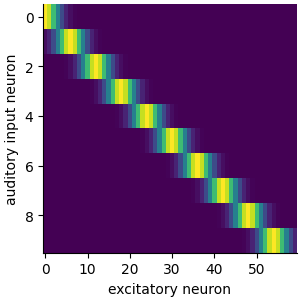

In [7]:
fig, ax = plt.subplots(1, figsize=(3,3))
ax.imshow(mapping[:10,:60], interpolation='none', aspect='auto')
ax.set(ylabel='auditory input neuron', xlabel='excitatory neuron')
# plt.plot(mapping[0,:10])

In [8]:
# diff = np.abs(aud_real['pert'] - aud_real['ctrl'])[...,400:500].mean(axis=(0,2))
# plt.hist(diff, bins=20);

In [9]:
# plt.hist(aud_real['ctrl'].flatten(), bins=100);
# aud_real['ctrl'].max()

In [10]:
T_post = 200
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 30 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [11]:
aud_idx = rng.choice(np.arange(aud_real['ctrl'].shape[0]), size=N_rend)
aud = np.zeros((T, NE))
for i in range(N_rend):
    t0 = T_burn+i*T_rend
    aud[t0:t0+T_song] = aud_real['ctrl'][aud_idx[i]].T

In [12]:
_ = np.arange(N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
save_W_ts = np.round(burst_ts[-1]).astype(int)
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
# for i in range(rH.shape[1]):
#     plt.plot(rH[:T_burn+T_rend,i], c='k', alpha=0.1+0.9*i/rH.shape[1])

In [13]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.8]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [14]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [15]:
r_rest = 2 # target rate when phi(0)
rmax, s = 50, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [16]:
tauE, tauI, dt = 30, 10, 1

In [47]:
w0_mean_HVC2E, w0_std_HVC2E, cW_HVC2E = 3/N_HVC, 1e-2, 1
w_inh_HVC2E = w0_mean_HVC2E*cW_HVC2E

netFF = WCNet(NE, N_HVC, w0_mean_HVC2E, phi, tauE, w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEI = EINet(NE, NI, N_HVC, w0_mean_HVC2E, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E, cW=cW_HVC2E)

Not a recurrent model and rI will not be calculated.


In [48]:
# hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
# hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# _ = netEI.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend], [], T_burn+T_rend, dt, 0)
# rE = _[0]
# fig, ax = plt.subplots(3, sharex='all')
# ax[0].plot(rH[:T_burn+T_rend])
# ax[1].plot(aud[:T_burn+T_rend,:5])
# ax[2].plot(rE[:T_burn+T_rend,:50]);

In [49]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-1e-2, 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netFF.sim(hE0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws_FF, mean_HVC_input = _
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-1e-2), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netEI.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws_EI, mean_HVC_input, hE = _
Ws_EI = Ws_EI['HVC']
if issparse(Ws_EI[0]):
    Ws_EI = [_.toarray() for _ in Ws_EI]

100%|███████████████████████████████████| 30499/30499 [00:11<00:00, 2610.86it/s]


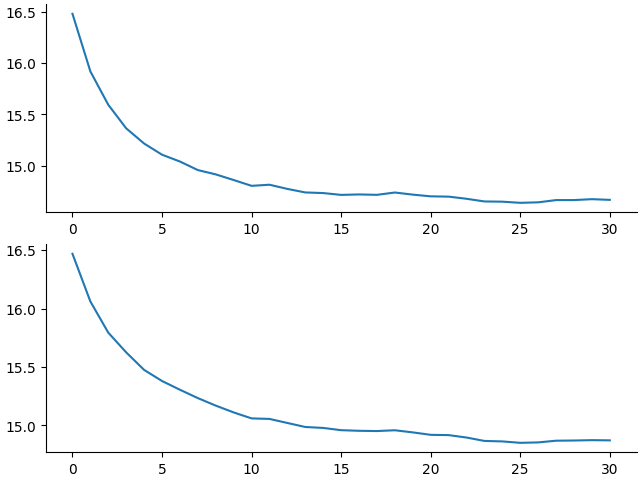

In [50]:
fig, ax = plt.subplots(2)
ax[0].plot([np.sqrt((_**2).sum()) for _ in Ws_FF])
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws_EI])

In [51]:
def plot_corr_mat(Ws, sort=False, vmin=-1, vmax=1):
    corrs = [correlation(Ws[i].T, aud_real['ctrl'].mean(axis=0).T, dim=2) 
             for i in (0,-1)] \
          + [correlation(Ws[-1].T, aud_real['pert_strong'].mean(axis=0).T, dim=2)]
    if sort:
        idx = np.argsort(np.nanargmin(corrs[1], axis=1))
    fig, ax = plt.subplots(1, 3, sharey='all', figsize=(5, 2))
    for i, j in enumerate(corrs):
        im = j if not sort else j[idx,:]
        im = ax[i].imshow(im, aspect='auto', interpolation='none', 
                          vmin=vmin, vmax=vmax, cmap='seismic')
    ax[0].set_title('Before learning\ncorrect song')
    ax[1].set_title('After learning\ncorrect song')
    ax[2].set_title('After learning\nperturbed song')
    cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[vmin, 0, vmax])
    return fig, ax

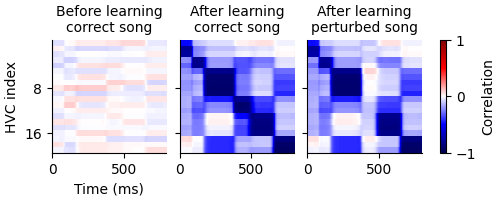

In [52]:
fig, ax = plot_corr_mat(Ws_FF)
ax[0].set(ylabel='HVC index', yticks=[8, 16], xlabel='Time (ms)')
fig.savefig('../svg/supplementary/FF_learn_res.svg')

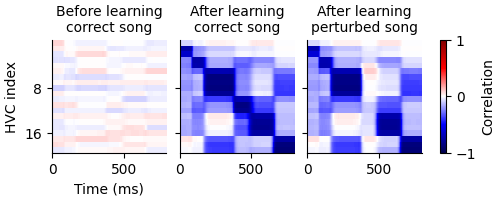

In [53]:
fig, ax = plot_corr_mat(Ws_EI)
ax[0].set(ylabel='HVC index', yticks=[8, 16], xlabel='Time (ms)')
fig.savefig('../svg/supplementary/EI_learn_res.svg')

277


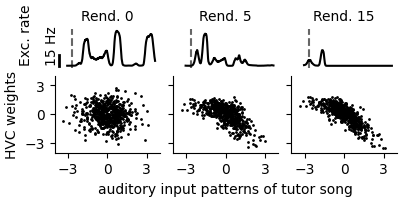

In [55]:
rends = (0, 5, 15)
_ = [rE[T_burn+j*T_rend:T_burn+(j+1)*T_rend-T_post].mean(axis=0) for j in rends]
k = rng.choice(np.where((_[0]>_[1]+0.5)&(_[1]>_[2]+0.5))[0])
print(k)
fig, ax = plt.subplots(2, 3, figsize=(4, 2), sharey='row', sharex='row', 
                       height_ratios=[1, 2])
for c, j in enumerate(rends):
    ax[0,c].plot(rE[T_burn+j*T_rend-50:T_burn+(j+1)*T_rend-T_post,k], color='k')
    ax[0,c].axvline(50, c='k', alpha=0.6, ls='--')
    ax[0,c].set_title('Rend. %d' % j, fontsize=10)
    ax[1,c].plot(normalize(aud_real['ctrl'][:,:,300:400].mean(axis=(0,2)), 0), 
                 normalize(Ws_EI[j][:,8], 0), '.', 
                 ms=2, color='k')
    ax[1,c].set(xlim=[-4, 4], ylim=[-4, 4], xticks=[-3, 0, 3])
    ax[0,c].set_axis_off()
ax[0,0].plot([-75, -75], [0, 15], c='k', lw=2)
ax[0,0].text(-150, 0, '15 Hz', va='bottom', ha='center', rotation=90)
ax[0,0].text(-400, 0, 'Exc. rate', va='bottom', ha='center', rotation=90)
# ax[0,0].legend(loc=(0, 1), title='Rendition #', ncols=3, frameon=False, 
#            handlelength=1, columnspacing=1)
ax[1,0].set(yticks=[-3, 0, 3], ylabel='HVC weights')
ax[1,1].set_xlabel('auditory input patterns of tutor song')
fig.savefig('../svg/training_res.svg')

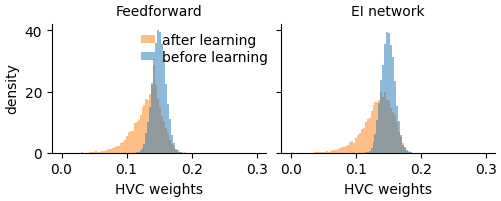

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharey='all')
ax[0].hist([Ws_FF[0].flatten(), Ws_FF[-1].flatten()], density=True, bins=100, 
           range=(0, 0.3), histtype='stepfilled', alpha=0.5, 
           label=['before learning', 'after learning'])
ax[1].hist([Ws_EI[0].flatten(), Ws_EI[-1].flatten()], density=True, bins=100, 
           range=(0, 0.3), histtype='stepfilled', alpha=0.5)
ax[0].set(xlabel='HVC weights', ylabel='density', title='Feedforward')
ax[1].set(xlabel='HVC weights', title='EI network')
fig.legend(loc=(0.27, 0.65))

In [26]:
w0_mean_E2E, w0_std_E2E, cW_E2E = 3/N_HVC, 0, 0.05
w_inh_E2E = w0_mean_E2E*cW_E2E

netEIrec = EINet(NE, NI, N_HVC, w0_mean_E2E, phiE, phiI, tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

In [27]:
# hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
# hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# _ = netEIrec.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend], [], T_burn+T_rend, dt, 1)
# rE = _[0]
# fig, ax = plt.subplots(3, sharex='all')
# ax[0].plot(rH[:T_burn+T_rend])
# ax[1].plot(aud[:T_burn+T_rend,:5])
# ax[2].plot(rE[:T_burn+T_rend,:5]);

In [28]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-1e-2), 
                         tauW=1e5, J0_mean=J0_mean, asyn_E=10, rE_th=1)
_ = netEIrec.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws, mean_HVC_input, hE = _
Ws = Ws['JEE']
if issparse(Ws[0]):
    Ws = [_.toarray() for _ in Ws]

100%|███████████████████████████████████| 30499/30499 [00:27<00:00, 1098.00it/s]


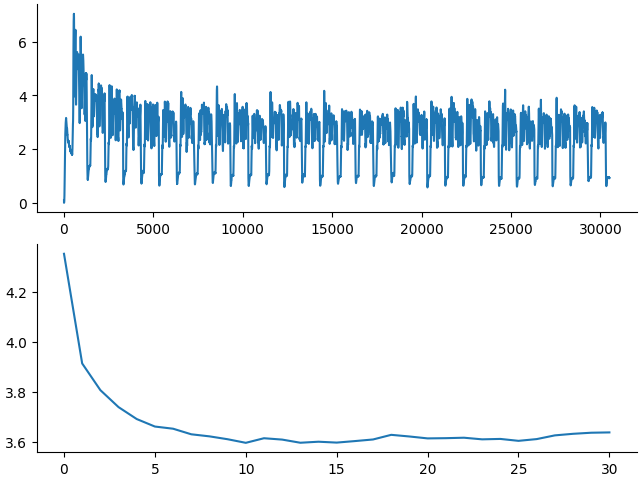

In [29]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws])

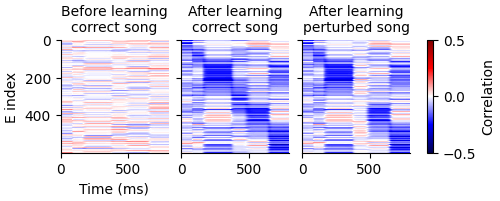

In [30]:
fig, ax = plot_corr_mat(Ws, sort=True, vmin=-0.5, vmax=0.5)
ax[0].set(ylabel='E index', xlabel='Time (ms)')
fig.savefig('../svg/supplementary/EIrec_learn_res.svg')

## Testing

In [31]:
T_pre = 0 # deprecated

In [32]:
N_test_rend = 20
T_test = T_burn+T_rend*N_test_rend
aud_pert_idx = rng.choice(np.arange(aud_real['pert_weak'].shape[0]), size=N_test_rend)
aud_pert_weak = np.zeros((T_test, NE))
aud_pert_strong = np.zeros((T_test, NE))
for i in range(N_test_rend):
    t0, t1 = T_burn+i*T_rend, T_burn+i*T_rend+T_song
    aud_pert_weak[t0:t1] = aud_real['pert_weak'][aud_pert_idx[i]].T
    aud_pert_strong[t0:t1] = aud_real['pert_strong'][aud_pert_idx[i]].T

In [33]:
def parse_trial(r):
    r = np.hstack(r) # E and I
    ret = np.zeros((N_test_rend, T_rend+T_pre, r.shape[-1]))
    for i in range(N_test_rend):
        ret[i] = r[T_burn+i*T_rend-T_pre:T_burn+(i+1)*T_rend]
    return ret

cases = ('ctrl', 'pert_weak', 'pert_strong', 'deaf')

In [34]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
res = {k: [] for k in cases}
for k, a in zip(cases, (aud[:T_test], aud_pert_weak, aud_pert_strong, aud_pert_weak*0)):
    res[k].append(parse_trial(netFF.sim(hE0, rH[:T_test], a, [], T_test, dt, 1)[:1]))
    res[k].append(parse_trial(netEI.sim(hE0, hI0, rH[:T_test], a, [], T_test, dt, 1)[:2]))
    res[k].append(parse_trial(netEIrec.sim(hE0, hI0, rH[:T_test], a, [], T_test, dt, 1)[:2]))

100%|███████████████████████████████████| 20499/20499 [00:05<00:00, 3688.37it/s]


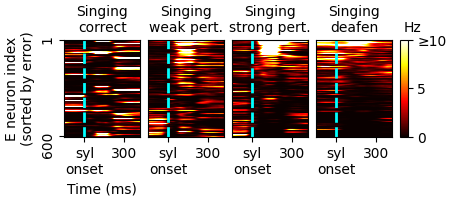

In [60]:
i = 0
_ = [res[k][1][i,:,:NE] for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
syl = aud_real['ctrl'][:,:,PERT_T0+T_pre:PERT_T1+T_pre].mean(axis=(0,2))
bos_weak_pert = aud_real['pert_weak'][i,:,PERT_T0+T_pre:PERT_T1+T_pre].mean(axis=1)
bos_strong_pert = aud_real['pert_strong'][i,:,PERT_T0+T_pre:PERT_T1+T_pre].mean(axis=1)
err = [np.zeros(NE), bos_weak_pert - syl, bos_strong_pert - syl, -syl]
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, PERT_T0+50, PERT_T1+100,
                                   figsize=(4.5, 2), plot_z=False, sort_by='e', th=10, tpre=100)
for i in range(len(ax)-1):
    ax[i].set(xticks=[100, 300], xticklabels=['syl\nonset', 300], xlabel='')
ax[0].set(xlabel='Time (ms)')
fig.savefig('../svg/err_response_EI.svg', transparent=True)

Text(0.5, 1.0, 'EI network\n(E$\\to$E)')

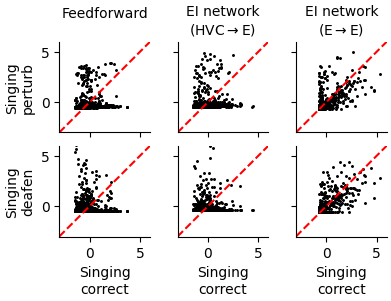

In [36]:
def avg_pert_window(rates, idx, pad=50):
    ret = []
    for i in range(rates.shape[0]):
        t0, t1 = int(aud_real['pert_t0'][idx[i]]), int(aud_real['pert_t1'][idx[i]])
        ret.append(rates[i,t0-pad:t1+pad*2].mean(axis=0))
    return np.mean(ret, axis=0)

fig, ax = plt.subplots(2, 3, sharex='all', sharey='all', figsize=(4, 3))
for i in range(3): 
    # z_ctrl = normalize(avg_pert_window(res['ctrl'][i][...,:NE], aud_idx), axis=0)
    z_ctrl = normalize(res['ctrl'][i][:,PERT_T0+T_pre:PERT_T1+T_pre,:NE].mean(axis=(0,1)), axis=0)
    for j, k in enumerate(('pert_strong', 'deaf')):
        # z_pert = normalize(avg_pert_window(res[k][i][...,:NE], aud_pert_idx), axis=0)
        z_pert = normalize(res[k][i][:,PERT_T0+T_pre:PERT_T1+T_pre,:NE].mean(axis=(0,1)), axis=0)
        ax[j,i].scatter(z_ctrl, z_pert, s=5, c='k')
        ax[j,i].plot([-3, 6], [-3,6], c='r', ls='--')
        ax[j,i].set(aspect=1, ylim=[-3,6], xlim=[-3,6])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nperturb')
ax[1,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(E$\\to$E)', fontsize=10)
fig.savefig('../svg/learn_real_joint_dist_without_I.svg')

Text(0.5, 1.0, 'EI network\n(E$\\to$E)')

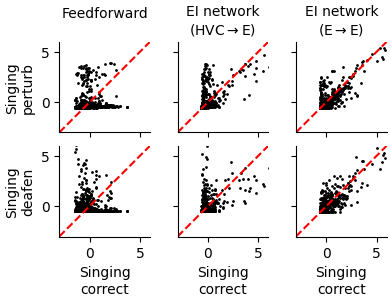

In [37]:
fig, ax = plt.subplots(2, 3, sharex='all', sharey='all', figsize=(4, 3))
for i in range(3): 
    z_ctrl = normalize(res['ctrl'][i][:,PERT_T0+T_pre:PERT_T1+T_pre].mean(axis=(0,1)), axis=0)
    for j, k in enumerate(('pert_strong', 'deaf')):
        z_pert = normalize(res[k][i][:,PERT_T0+T_pre:PERT_T1+T_pre].mean(axis=(0,1)), axis=0)
        ax[j,i].plot(z_ctrl, z_pert, 'o', ms=1, c='k')
        ax[j,i].plot([-3, 6], [-3,6], c='r', ls='--')
        ax[j,i].set(aspect=1, ylim=[-3,6], xlim=[-3,6])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nperturb')
ax[1,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(E$\\to$E)', fontsize=10)
fig.savefig('../svg/learn_real_joint_dist_with_I.svg')

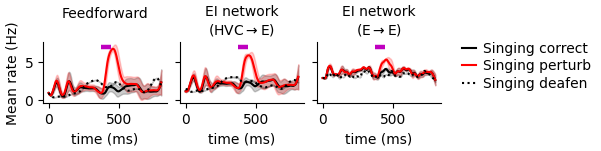

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(6,1.5), sharey='all')
for i, k in enumerate(('Feedforward\n', 'EI network\n(HVC$\\to$E)', 
                       'EI network\n(E$\\to$E)')):
    for j, c in zip(('ctrl', 'pert_strong', 'deaf'), ('k', 'r', 'k')):
        aux = res[j][i][:,T_pre:-T_post].mean(axis=-1)
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, 
                      ls='-' if j!='deaf' else ':')
        ax[i].hlines(7, aud_real['pert_t0'].mean()-aud_real['pert_t0'].std(), 
                        aud_real['pert_t1'].mean()+aud_real['pert_t1'].std(),
                     lw=3, color='m')
    ax[i].set(xlabel='time (ms)', title=k)
ax[0].set_ylabel('Mean rate (Hz)')
ax[-1].set_axis_off() # dummy
for k, c in zip(('correct', 'perturb', 'deafen'), ('k', 'r', 'k')):
    ax[-1].plot(0,0, c=c, ls='-' if k!='deafen' else ':', label='Singing '+k)
ax[-1].legend()
fig.savefig('../svg/learn_real_mean_rates.svg')

0 0
0 1
1 0
1 1
2 0
2 1
0 0
0 1
1 0
1 1
2 0
2 1
0 0
0 1
1 0
1 1
2 0
2 1


Text(0.5, 1.0, '\n')

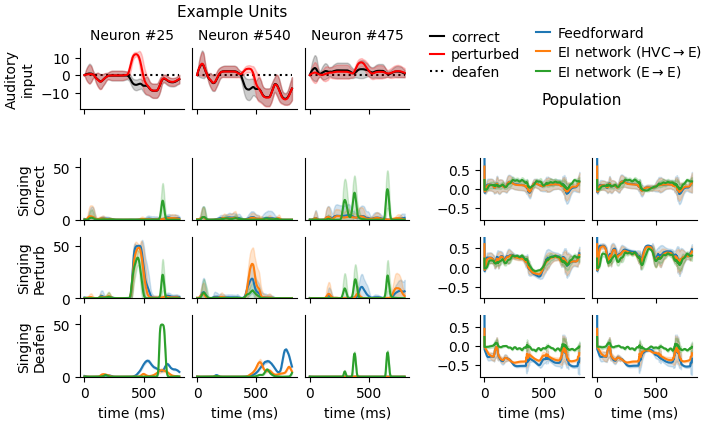

In [45]:
diff = (aud_real['pert_strong'] - aud_real['ctrl'])[...,400:500].mean(axis=(0,2))
q0, q1, q2 = np.quantile(diff, [0.75, 0.8, 0.95])
ls = (rng.choice(np.where(diff>q2)[0]), 
      rng.choice(np.where((diff<q2)&(diff>q1))[0]), 
      rng.choice(np.where((diff<q1)&(diff>q0))[0]))
assert (np.array(ls) < NE).all() # shouldn't involve I neurons

# pat_ctrl = aud_real['ctrl'][aud_idx,:,400:500].mean(axis=(0,2))[None,None,:]
# pat_pert = aud_real['pert_strong'][aud_idx,:,400:500].mean(axis=(0,2))[None,None,:]
# pat_ctrl = aud_real['ctrl'][aud_pert_idx,:,400:500].mean(axis=2)[:,None,:]
# pat_pert = aud_real['pert_strong'][aud_pert_idx,:,400:500].mean(axis=2)[:,None,:]
pat_ctrl = np.swapaxes(aud_real['ctrl'][aud_pert_idx], 1, 2) + 1e-3
pat_pert = np.swapaxes(aud_real['pert_strong'][aud_pert_idx], 1, 2) + 1e-3

ks = ('Feedforward', 'EI network (HVC$\\to$E)', 'EI network (E$\\to$E)')
fig, ax = plt.subplots(4, 6, sharex='all', figsize=(7,4), width_ratios=[1]*3+[0.1]+[1]*2)

#### Plot input ####
for j, l in enumerate(ls):
    line1, = plot_mean_std(ax[0,j], aud_real['ctrl'][:,l,:].mean(axis=0), 
                           aud_real['ctrl'][:,l,:].std(axis=0), a_fill=0.2, 
                           c='k', label='correct')
    line2, = plot_mean_std(ax[0,j], aud_real['pert_strong'][:,l,:].mean(axis=0), 
                           aud_real['pert_strong'][:,l,:].std(axis=0), a_fill=0.2, 
                           c='r', label='perturbed')
    line3, = ax[0,j].plot(np.zeros(aud_real['ctrl'].shape[-1]), c='k', 
                          label='deafen', ls=':', zorder=-1)
    # if j == 0:
fig.legend(handles=[line1, line2, line3], loc=(0.6, 0.8))

#### Plot individual neurons & populations ####
lines = []
for i, k in enumerate(ks):
    c = 'C%d' % i
    for m, n in enumerate(('ctrl', 'pert_strong', 'deaf')):
        for j, l in enumerate(ls):
            _ = res[n][i][:,T_pre:-T_post,l]
            _ = plot_mean_std(ax[m+1,j], _.mean(axis=0), _.std(axis=0), 
                              a_fill=0.2, c=c, label=k)[0]
            if m == 0 and j == 0:
                lines.append(_)
            ax[0,j].set(title='Neuron #%d' % l)
            ax[-1,j].set_xlabel('time (ms)')
        for j, z in enumerate((pat_ctrl, pat_pert)):
            _ = correlation(res[n][i][:,T_pre:-T_post,:NE], z, dim=1, cosine=True)
            plot_mean_std(ax[m+1,j+4], _.mean(axis=0), _.std(axis=0), a_fill=0.2, c=c)
            ax[m+1,j+4].set(ylim=[-0.8,0.8])
            ax[-1,j+4].set_xlabel('time (ms)')
            if j > 0:
                ax[m+1,j+4].set(yticks=[])
            ax[0,j+4].set_axis_off()
            ax[0,3].set_axis_off()
            ax[m+1,3].set_axis_off()
    # if j == 0:
fig.legend(handles=lines, loc=(0.75, 0.8))

# rm yticks and share y for input
ymin = min(map(lambda x: x.get_ylim()[0], ax[0,:3]))
ymax = max(map(lambda x: x.get_ylim()[1], ax[0,:3]))
for j in range(3):
    ax[0,j].set(ylim=[ymin,ymax])
    if j > 0:
        ax[0,j].set(yticks=[])

# rm yticks and share y for neurons
ymax = max(map(lambda x: x.get_ylim()[1], ax[1:-1,:3].flatten()))
for i in range(1, 4):
    for j in range(3):
        ax[i,j].set(ylim=[0,ymax])
        if j > 0:
            ax[i,j].set(yticks=[])

fig.text(0.33, 1.02, 'Example Units', ha='center', fontsize=11)
fig.text(0.83, 0.8, 'Population', ha='center', fontsize=11)

ax[0,0].set_ylabel('Auditory\ninput')
ax[1,0].set_ylabel('Singing\nCorrect')
ax[2,0].set_ylabel('Singing\nPerturb')
ax[3,0].set_ylabel('Singing\nDeafen')
ax[1,4].set_title('\n')
ax[1,4].set_title('\n')
# ax[1,4].set_title('Similarity with\ncorrect pattern')
# ax[1,5].set_title('Similarity with\nperturbed pattern')
# fig.savefig('../svg/learn_real_single_neurons_and_pop_response.svg', bbox_inches='tight')